In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import calendar as cld
import mysql.connector  
import numpy as np

Reading from csv files to dataframes

In [42]:
ipl_df = pd.read_csv('all_matches.csv')
match_df = pd.read_csv('matches_info.csv')

Removing unwanted columns

In [43]:
ipl_df.drop('Unnamed: 0', axis = 1, inplace = True)
match_df.drop('Unnamed: 0', axis = 1, inplace = True)

Analysing 9 best performing teams - Match Wins & Percentage Match Wins

In [44]:
winner_df= pd.DataFrame(match_df.groupby('winner')['winner'].count())
winner_df.columns = ['wins']

match_wins = winner_df.sort_values('wins', ascending = False).head(9)

total_match = pd.DataFrame(match_df.groupby('team1')['team1'].count()+match_df.groupby('team2')['team2'].count())
total_match.columns = ['match_played']
total_match.index.name = 'team'

percentage_wins = pd.DataFrame((winner_df.sort_index().wins/total_match.sort_index().match_played)*100)
percentage_wins.columns = ['win%']

team_wins = match_wins.merge(percentage_wins, on = 'winner', how = 'left')
team_wins['wins'] = pd.to_numeric(team_wins['wins'])
team_wins

,wins,win%
winner,,
Mumbai Indians,129,55.844156
Chennai Super Kings,121,58.173077
Kolkata Knight Riders,113,50.672646
Royal Challengers Bangalore,107,47.345133
Punjab Kings,98,44.954128
Rajasthan Royals,94,48.958333
Sunrisers Hyderabad,74,48.684211
Delhi Daredevils,67,41.614907
Delhi Capitals,33,52.380952


Plotting Pie Chart for Wins Share of teams wrt to total IPL wins

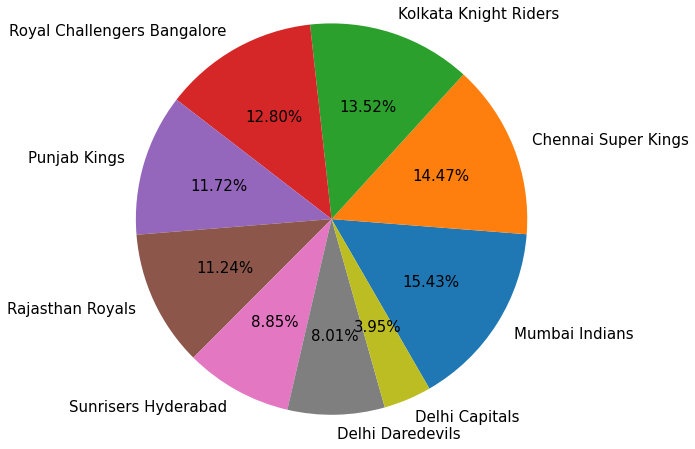

In [45]:
plt.rcParams['figure.figsize'] = (3,3)
plt.pie(match_wins.wins, radius = 3, labels = match_wins.index, autopct = "%0.2f%%", startangle = -60, textprops={'fontsize': 15});

Plotting Absolute win counts & win counts as a percentage of matches played

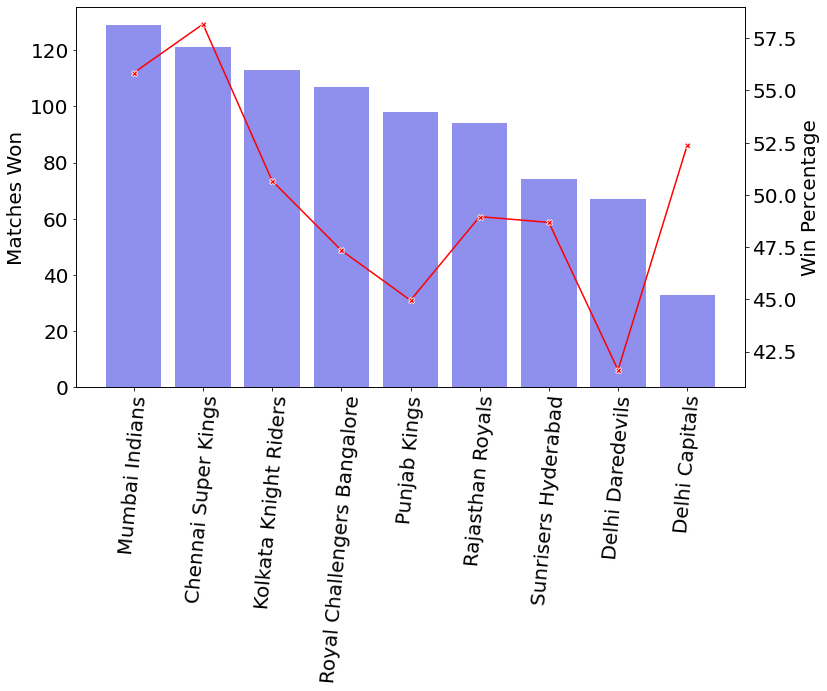

In [46]:
plt.rcParams['figure.figsize'] = (12,7)
plt.xticks(rotation=85, fontsize=20)
sns.barplot(x = team_wins.index, y = 'wins', data = team_wins, color = 'blue', alpha = 0.5);
plt.xlabel('')
plt.ylabel('Matches Won', fontsize = 20)
plt.yticks(fontsize=20)
ax2 = plt.twinx()
sns.lineplot(x = team_wins.index, y = 'win%', data = team_wins, color = 'red', ax=ax2, marker = 'X');
plt.yticks(fontsize=20)
plt.ylabel('Win Percentage', fontsize = 20);

Toss Analysis over all matches

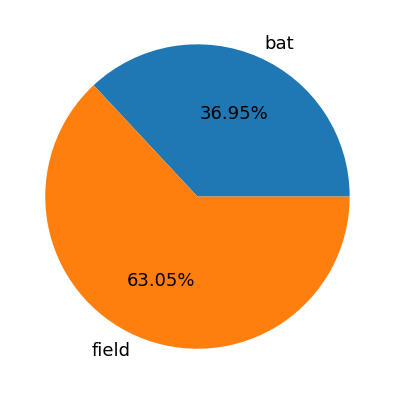

In [47]:
toss_df = pd.DataFrame(match_df.groupby('toss_decision')['toss_decision'].count())
toss_df.columns = ['counts']
plt.pie(toss_df.counts, labels = toss_df.index, textprops={'fontsize': 18}, autopct = "%0.2f%%");

Toss Analysis per venue

In [48]:
venue_matches = pd.DataFrame(match_df.groupby('venue')['venue'].count())
venue_matches.columns = ['Matches']
venue_matches.sort_values('Matches', ascending = False, inplace = True)

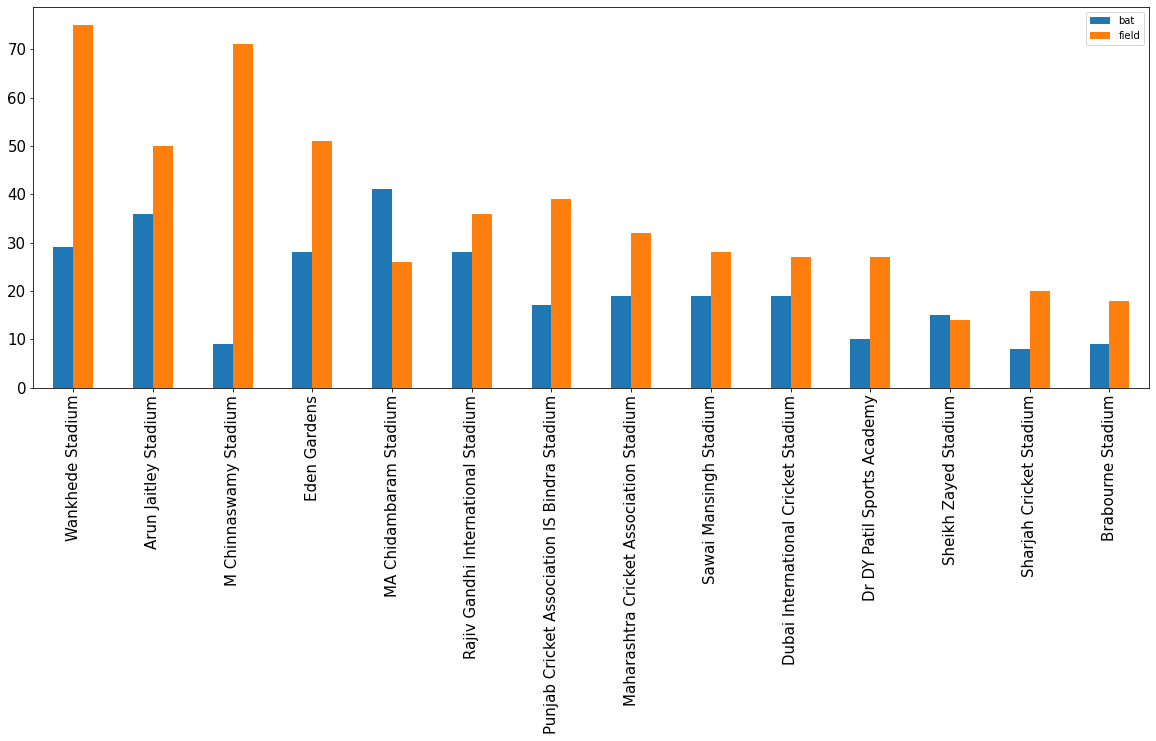

In [49]:
toss_venue = pd.DataFrame(match_df.groupby(['venue', 'toss_decision'])['toss_decision'].count().unstack())
toss_venue = venue_matches[venue_matches['Matches']>15].merge(toss_venue, on = 'venue')
toss_venue.plot(y = ['bat','field'], figsize = (20,7), rot = 90, kind = 'bar', fontsize= 15, xlabel = '');

Merging Dataframes

In [50]:
merged_df = ipl_df.merge(match_df, left_on ='match_id', right_on ='Match_ID')
merged_df.columns.values

array(['match_id', 'season_x', 'start_date', 'venue_x', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'over_number',
       'ball_number', 'total_runs_per_ball', 'Match_ID', 'team1', 'team2',
       'season_y', 'date', 'venue_y', 'city', 'toss_winner',
       'toss_decision', 'winner', 'Margin', 'Margin_Type',
       'player_of_match'], dtype=object)

Dropping duplicate columns & renaming columns

In [51]:
merged_df = merged_df.drop(['start_date', 'venue_x', 'Match_ID', 'season_y'], axis = 1)
merged_df = merged_df.rename(columns = {'season_x' : 'season', 'venue_y' : 'venue'})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225954 entries, 0 to 225953
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   match_id             225954 non-null  int64  
 1   season               225954 non-null  int64  
 2   innings              225954 non-null  int64  
 3   ball                 225954 non-null  float64
 4   batting_team         225954 non-null  object 
 5   bowling_team         225954 non-null  object 
 6   striker              225954 non-null  object 
 7   non_striker          225954 non-null  object 
 8   bowler               225954 non-null  object 
 9   runs_off_bat         225954 non-null  int64  
 10  extras               225954 non-null  int64  
 11  wides                225954 non-null  int64  
 12  noballs              225954 non-null  int64  
 13  byes                 225954 non-null  int64  
 14  legbyes              225954 non-null  int64  
 15  penalty          

Best Batsmen Analysis - Career Runs & Runs in Winning Contribution

In [52]:
highest_runs = pd.DataFrame(merged_df.groupby('striker')['runs_off_bat'].sum().nlargest(10))
highest_runs = highest_runs.rename(columns = {'runs_off_bat' : 'runs'})
highest_runs.sort_values('runs', ascending = False, inplace=True)

highest_winning_runs = pd.DataFrame(merged_df[(merged_df.winner == merged_df.batting_team)].groupby('striker')['runs_off_bat'].sum().nlargest(10))
highest_winning_runs = highest_winning_runs.rename(columns = {'runs_off_bat' : 'runs'})
highest_winning_runs.sort_values('runs', ascending = False, inplace=True)

best_batsmen = pd.DataFrame(highest_runs.merge(highest_winning_runs, on ='striker', how = 'outer').rename(columns = {'runs_x':'runs', 'runs_y':'winning_contribution'}))
best_batsmen = best_batsmen.sort_values('winning_contribution', ascending = False)
best_batsmen

,runs,winning_contribution
striker,,
S Dhawan,6244.0,3761.0
RG Sharma,5881.0,3576.0
SK Raina,5536.0,3559.0
DA Warner,5883.0,3502.0
V Kohli,6634.0,3459.0
CH Gayle,4997.0,3116.0
AB de Villiers,5181.0,2967.0
MS Dhoni,4978.0,2938.0
G Gambhir,NaN,2839.0


PLotting Batsmen Analysis - Career Runs & Runs in Winning Contribution

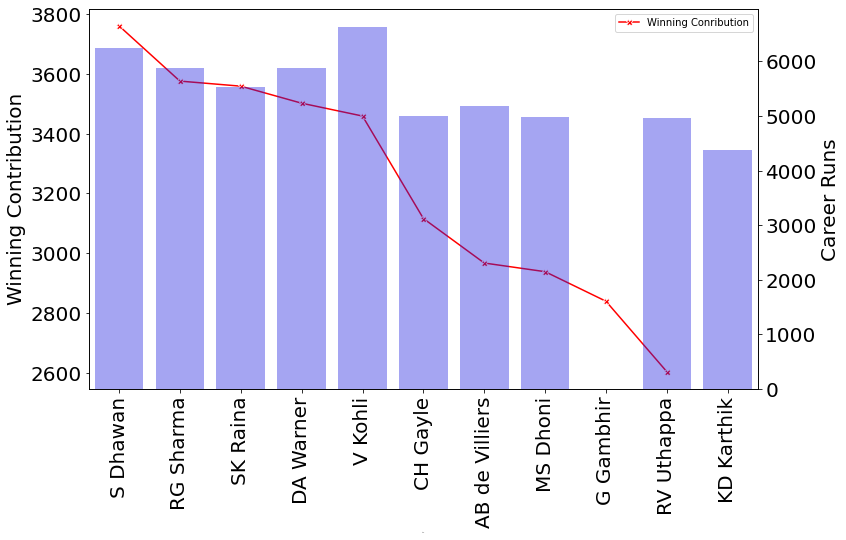

In [53]:
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize = 0)
plt.ylabel('Winning Contribution', fontsize = 20);
sns.lineplot(data = best_batsmen, x = best_batsmen.index, y = 'winning_contribution',  color = 'red', label = 'Winning Conribution', marker = 'X')
ax2 = plt.twinx()
plt.yticks(fontsize=20)
sns.barplot(data = best_batsmen, x = best_batsmen.index, y = 'runs', color = 'blue', alpha = 0.4, ax = ax2)
plt.ylabel('Career Runs', fontsize = 20);

Best Bowler Analysis - Career Wickets & Wickets in Winning Contribution

In [54]:
highest_wickets = pd.DataFrame(merged_df[merged_df.wicket_type.isin(['caught','bowled', 'lbw', 'stumped','caught and bowled','hit wicket'])
                                        ].groupby('bowler')['wicket_type'].count().nlargest(10))
highest_wickets = highest_wickets.rename(columns = {'wicket_type' : 'career_wickets'})
highest_wickets.sort_values('career_wickets', ascending = False, inplace=True)

highest_winning_wickets = pd.DataFrame(merged_df[(merged_df.winner == merged_df.bowling_team) & 
                                                 (merged_df.wicket_type.isin(['caught','bowled', 'lbw', 'stumped','caught and bowled',
                                                                              'hit wicket']))].groupby('bowler')['wicket_type'
                                                                                                                ].count().nlargest(10))
highest_winning_wickets = highest_winning_wickets.rename(columns = {'wicket_type' : 'winning_contribution_wickets'})
highest_winning_wickets.sort_values('winning_contribution_wickets', ascending = False, inplace=True)

best_bowler = pd.DataFrame(highest_wickets.merge(highest_winning_wickets, on ='bowler', how = 'outer'))
best_bowler = best_bowler.sort_values('winning_contribution_wickets', ascending = False)
best_bowler

,career_wickets,winning_contribution_wickets
bowler,,
SL Malinga,170.0,122.0
DJ Bravo,183.0,115.0
R Ashwin,157.0,103.0
Harbhajan Singh,150.0,103.0
A Mishra,166.0,97.0
RA Jadeja,NaN,95.0
PP Chawla,157.0,94.0
SP Narine,152.0,90.0
JJ Bumrah,148.0,89.0


Plotting Bowler Analysis - Career Wickets & Wickets in Winning Contribution

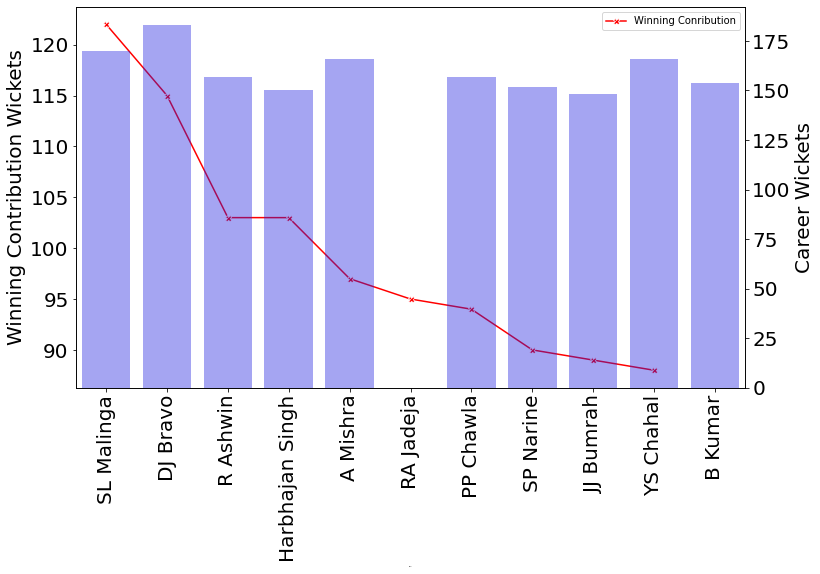

In [55]:
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize = 0)
plt.ylabel('Winning Contribution Wickets', fontsize = 20);
sns.lineplot(data = best_bowler, x = best_bowler.index, y = 'winning_contribution_wickets',  
             color = 'red', label = 'Winning Conribution', marker = 'X')
ax2 = plt.twinx()
plt.yticks(fontsize=20)
sns.barplot(data = best_bowler, x = best_bowler.index, y = 'career_wickets', color = 'blue', alpha = 0.4, ax = ax2)
plt.ylabel('Career Wickets', fontsize = 20);

Analysis - Impact of Scores in 30s, 40s, 50s, 60s, 70s, 80s, 90s & >100s on Match Results

In [56]:
batting_score_win = pd.DataFrame(merged_df[(merged_df.winner == merged_df.batting_team)
                                          ].groupby(['match_id','striker'])['runs_off_bat'].sum())
batting_score_win.rename(columns = {'runs_off_bat' : 'runs'}, inplace = True)
score30s = len(batting_score_win[batting_score_win['runs'].isin(range(30, 41))])
score40s = len(batting_score_win[batting_score_win['runs'].isin(range(41, 51))])
score50s = len(batting_score_win[batting_score_win['runs'].isin(range(51, 61))])
score60s = len(batting_score_win[batting_score_win['runs'].isin(range(61, 71))])
score70s = len(batting_score_win[batting_score_win['runs'].isin(range(71, 81))])
score80s = len(batting_score_win[batting_score_win['runs'].isin(range(81, 91))])
score90s = len(batting_score_win[batting_score_win['runs'].isin(range(91, 101))])
score100s = len(batting_score_win[batting_score_win['runs']>100])
win_list = pd.DataFrame([score30s, score40s, score50s, score60s, score70s, score80s, score90s, score100s],
                        ['score30s', 'score40s', 'score50s', 'score60s', 'score70s', 'score80s', 'score90s', 'score>100s'], 
                        columns = ['count'])
#win_list = win_list.drop(0, axis = 1)

batting_score_all = pd.DataFrame(merged_df.groupby(['match_id','striker'])['runs_off_bat'].sum())
batting_score_all.rename(columns = {'runs_off_bat' : 'runs'}, inplace = True)
score30s = len(batting_score_all[batting_score_all['runs'].isin(range(30, 41))])
score40s = len(batting_score_all[batting_score_all['runs'].isin(range(41, 51))])
score50s = len(batting_score_all[batting_score_all['runs'].isin(range(51, 61))])
score60s = len(batting_score_all[batting_score_all['runs'].isin(range(61, 71))])
score70s = len(batting_score_all[batting_score_all['runs'].isin(range(71, 81))])
score80s = len(batting_score_all[batting_score_all['runs'].isin(range(81, 91))])
score90s = len(batting_score_all[batting_score_all['runs'].isin(range(91, 101))])
score100s = len(batting_score_all[batting_score_all['runs']>100])
all_list = pd.DataFrame([score30s, score40s, score50s, score60s, score70s, score80s, score90s, score100s],
                        ['score30s', 'score40s', 'score50s', 'score60s', 'score70s', 'score80s', 'score90s', 'score>100s'],
                       columns = ['count'])
#all_list = all_list.drop(0, axis = 1)


all_list.merge(win_list, left_on=all_list.index, right_on = win_list.index
              ).rename(columns = {'key_0' : 'scores', 'count_x':'all_matches', 'count_y':'Win Matches'})

,scores,all_matches,Win Matches
0,score30s,1303,663
1,score40s,786,425
2,score50s,557,294
3,score60s,363,221
4,score70s,208,132
5,score80s,128,93
6,score90s,82,59
7,score>100s,64,51


Plotting - Impact of Scores in 30s, 40s, 50s, 60s, 70s, 80s, 90s & >100s on Match Results

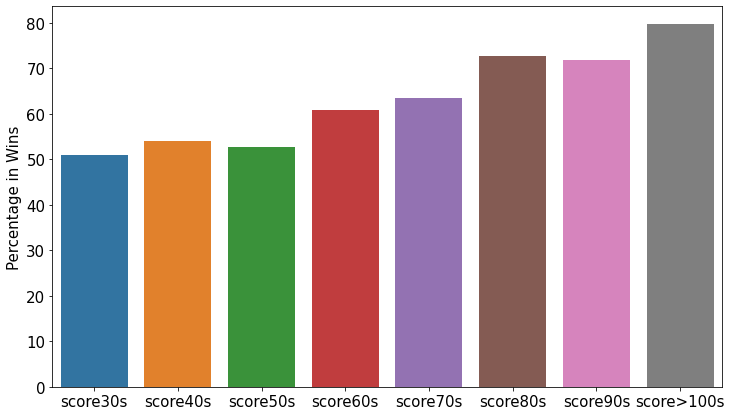

In [57]:
perc_list = ((win_list/all_list)*100)
perc_list = perc_list.rename(columns = {'count':'wins_perc'})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
sns.barplot(data = perc_list, y = 'wins_perc', x=perc_list.index)
plt.ylabel('Percentage in Wins', fontsize = 15);